# 1. Introduction

Solving the 3D structures of biomolecules, such as proteins and nucleic acids, is key to understanding their function and the mechanisms underlying biological processes. For this purpose, cryogenic electron microscopy (cryo-EM) has become in recent years the most used technique to solve structures. One main advantage of the technique, in contrast with X-ray crystallography, is that it makes possible the reconstruction of biomolecules in various conformations (or 3D configurations) that they can adopt. In this context, once different conformations are obtained as 3D EM density maps (which can be seen as a large 3D grid of voxels with different levels of intensities), a first step is to align them in the 3D space to further study their differences and similarities, fit atomic models of a biological structure to the other one, analyze conformational states of a protein, or even morph the pathway between two conformational states.

**References**

Evans, Philip, and Airlie McCoy. "An introduction to molecular replacement." Acta Crystallographica Section D: Biological Crystallography 64.1 (2008): 1-10.  
Joseph, Agnel Praveen, et al. "Comparing cryo-EM reconstructions and validating atomic model fit using difference maps." Journal of chemical information and modeling 60.5 (2020): 2552-2560.  
Ecoffet, Arthur, Frédéric Poitevin, and Khanh Dao Duc. "MorphOT: Transport-based interpolation between EM maps with UCSF ChimeraX." bioRxiv (2020).

To solve the rigid body alignment problem for 3D cryo-EM density maps, standard approaches use various optimization algorithms to optimize the correlation or overlap of two given density maps. However, with these objective functions, this step remains costly and challenging, with standard alignment tools getting potentially stuck in local minima. So, the goal of this project is to introduce a novel approach, called *AlignOT*, that is based on an alternative objective function (their Wasserstein distance). For this, we need a point-cloud representation of 3D maps, to compute and minimize their Wasserstein distance with a stochastic gradient algorithm.

In other words, AlignOT finds a 3D rotation and a translation vector that minimizes the following cost function.

\begin{equation}\label{eq:loss}
\mathcal{L}(R, T) = \mathcal{W}_{2,\epsilon}^2(\text{move}_{R,T}(\mathbf{A}),\mathbf{B})^2, \tag{1}
\end{equation}
where $\mathbf{A}=(a_1,\ldots,a_n)$ and $\mathbf{B}= (b_1,\ldots, b_n)$ are two sets of points, $R \in \mathbb{R}^{3 \times 3}$ is an orthogonal rotation matrix and $T \in \mathbb{R}^3$ is a translation vector. Also, $\text{move}_{R,T}(\mathbf{A})$ is defined as

\begin{equation}\label{eq:move}
\text{move}_{R,T}(\mathbf{A}) = \{Ra_i + T| a_i \in \mathbf{A}\}.
\end{equation}
Finally, $\mathcal{W}_{2,\epsilon}^2$ is the entropy regularized Wasserstein distance computed in the Optimal Transport problem (discussed in the class).

**References**

Peyré, Gabriel, and Marco Cuturi. "Computational optimal transport: With applications to data science." Foundations and Trends® in Machine Learning 11.5-6 (2019): 355-607.

To run the rest of the notebook and our project you need the following packages.

In [ ]:
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install mrcfile
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install Pillow
!{sys.executable} -m pip install POT
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install numba
!{sys.executable} -m pip install tornado==4.5.3
!pip freeze

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import math
import numpy as np
import ot
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d import Axes3D
import random
import time
import seaborn as sns
import json

import mrcfile
import pandas as pd
import trn, coords, gauss_forward_model
import importlib
importlib.reload(trn)

plt.rcParams["figure.figsize"] = (7,5)

# 2. Backgrounds

## 2.1. Quaternions
We use [Quaternions](https://en.wikipedia.org/wiki/Quaternion) as a formalization of 3D rotation e.g. elements of $SO(3)$. To make our way simple we write the following classes for quaternion calculations. The class `Term` is representing a multivariate monomial term (more precisely we only work with 4 and 8 variables in this project) demonstrated as $\textrm{coef} \times \Pi_{i=1}^8X_i^{\textrm{exps}[i]}$. The class `Polynomial` is representing a multivariate polynomial built as a sum of some `Term`s. Finally, the class `Quaternion` is representing a quaternion that is composed of polynomials. For simplicity, we write addition, multiplication, derivation, and evaluation function for all these classes.

In [2]:
class Term:
    def __init__(self, coef=1, exps=[0,0,0,0]):
        self.coef = coef
        self.exps = exps
        while len(self.exps) < 8:
            self.exps.append(0)
    
    def derivative(self, index):
        new_exps = [0,0,0,0,0,0,0,0]
        for i in range(8):
            if i != index:
                new_exps[i] = self.exps[i]
            else:
                new_exps[i] = self.exps[i] - 1
        return Term(coef=self.coef*self.exps[index], exps=new_exps)
    
    def evaluate(self, vals):
        s = self.coef
        if s == 0:
            return 0
        for i in range(min(len(vals), len(self.exps))):
            if self.exps[i] == 0:
                continue
            elif self.exps[i] == 1:
                s *= vals[i]
            elif self.exps[i] == 2:
                s *= vals[i] * vals[i]
            elif self.exps[i] == 3:
                s *= vals[i] * vals[i] * vals[i]
            else:
                print(self.exps[i])
                s *= vals[i] ** self.exps[i]
        return s
    
    def bunch_evaluate(self, bunch_vals):
        s = self.coef
        for i in range(min(len(bunch_vals), len(self.exps))):
            for j in range(self.exps[i]):
                s = np.multiply(s, bunch_vals[i])
        return s
    
    def __mul__(self, other):
        coef = self.coef * other.coef
        exps = []
        for i in range(8):
            exps.append(self.exps[i] + other.exps[i])
        return Term(coef=coef, exps=exps)
    
    def __neg__(self):
        return Term(coef=-self.coef, exps=self.exps)
    
    def __str__(self):
        s = ""
        for i in range(8):
            if self.exps[i] != 0:
                s += "q" + str(i) + "^" + str(self.exps[i])
        return str(self.coef) + "*" + s
    
    def is_similar(self, other):
        for i in range(8):
            if self.exps[i] != other.exps[i]:
                return False
        return True
    
    def simplify(self, vals):
        new_exps = [0,0,0,0,0,0,0,0]
        coef = self.coef
        for i in range(8):
            if vals[i] != 'x':
                coef *= vals[i]**self.exps[i]
            else:
                new_exps[i] = self.exps[i]
        return Term(coef=self.coef*self.exps[index], exps=new_exps)
        
    
class Polynomial:
    def __init__(self, terms=None):
        if terms is None:
            terms = []
        self.terms = {}
        for term in terms:
            self.terms[tuple(term.exps)] = term
        
    def add_term(self, term):
        if term.coef == 0:
            return
        if tuple(term.exps) not in self.terms:
            self.terms[tuple(term.exps)] = term
        else:
            self.terms[tuple(term.exps)].coef += term.coef

    def get_terms(self):
        terms = []
        for exps in self.terms:
            terms.append(self.terms[exps])
        return terms
        
    def derivative(self, index):
        res = Polynomial()
        for term in self.get_terms():
            res.add_term(term.derivative(index))
        return res
    
    def simplify(self, vals):
        res = ()
        for term in self.get_terms():
            res.add_term(term.simplify(vals))
        return res
    
    def evaluate(self, vals):
        t = 0
        for term in self.get_terms():
            t += term.evaluate(vals)
        return t
    
    def bunch_evaluate(self, bunch_vals):
        t = 0
        for term in self.get_terms():
            t = np.add(t, term.bunch_evaluate(bunch_vals))
        return t
    
    def __add__(self, other):
        res = Polynomial()
        for term in self.get_terms():
            res.add_term(term)
        for term in other.get_terms():
            res.add_term(term)
        return res
    
    def __sub__(self, other):
        res = Polynomial()
        for term in self.get_terms():
            res.add_term(term)
        for term in other.get_terms():
            res.add_term(-term)
        return res
    
    def __neg__(self):
        res = Polynomial()
        for term in self.get_terms():
            res.add_term(-term)
        return res
    
    def __mul__(self, other):
        res = Polynomial()
        for term1 in self.get_terms():
            for term2 in other.get_terms():
                res.add_term(term1*term2)
        return res
    
    def __str__(self):
        s = ""
        terms = self.get_terms()
        for i in range(len(terms)):
            if i > 0:
                s += " + "
            s += str(terms[i])
        return s

class Quaternion:
    def __init__(self, real_pol, i_pol, j_pol, k_pol):
        self.real_pol = real_pol
        self.i_pol = i_pol
        self.j_pol = j_pol
        self.k_pol = k_pol
        
    def conjugate(self):
        return Quaternion(self.real_pol, -self.i_pol, -self.j_pol, -self.k_pol)
    
    def __mul__(self, other):
        return Quaternion(self.real_pol*other.real_pol - self.i_pol*other.i_pol - self.j_pol*other.j_pol - self.k_pol*other.k_pol,
                          self.real_pol*other.i_pol + self.i_pol*other.real_pol + self.j_pol*other.k_pol - self.k_pol*other.j_pol,
                          self.real_pol*other.j_pol + self.j_pol*other.real_pol + self.k_pol*other.i_pol - self.i_pol*other.k_pol,
                          self.real_pol*other.k_pol + self.k_pol*other.real_pol + self.i_pol*other.j_pol - self.j_pol*other.i_pol)
    
    def __str__(self):
        return str(self.real_pol) + " + (" + str(self.i_pol) + ")i + (" + str(self.j_pol) + ")j + (" + str(self.k_pol) + ")k"
    


Here are some examples of our implementation.

In [3]:
q = Quaternion(Polynomial([Term(coef=1, exps=[1,0,0,0])]), Polynomial([Term(coef=1, exps=[0,1,0,0])]), 
               Polynomial([Term(coef=1, exps=[0,0,1,0])]), Polynomial([Term(coef=1, exps=[0,0,0,1])]))
qs = q.conjugate()
print('The conjugate of %s is %s.'%(str(q), str(qs)))
print('The multiplication of %s and %s is equal to %s.'%(str(q), str(qs), str(q*qs)))

The conjugate of 1*q0^1 + (1*q1^1)i + (1*q2^1)j + (1*q3^1)k is 1*q0^1 + (-1*q1^1)i + (-1*q2^1)j + (-1*q3^1)k.
The multiplication of 1*q0^1 + (1*q1^1)i + (1*q2^1)j + (1*q3^1)k and 1*q0^1 + (-1*q1^1)i + (-1*q2^1)j + (-1*q3^1)k is equal to 1*q0^2 + 1*q1^2 + 1*q2^2 + 1*q3^2 + (0*q2^1q3^1)i + (0*q1^1q3^1)j + (0*q1^1q2^1)k.


Also, to make our way even simpler, we write some utility functions to convert the angle/axis representation of a rotation to quaternion representation and to apply a rotation generated by a quaternion to a point cloud. These functions will be used frequently in the following sections.

In [4]:
def get_quaternion_vals(theta, ax, ay, az):
    """
    Compute the quaternion representation for a given rotation in angle-axis representation
    params:
        theta: the angle of the rotation in radians
        ax, ay, az: three floats in a way that *ax, ay, az) shows the 3d axis of the rotation

    retrun:
        q: is a list of length 4 that has values of the corresponding quaternion
    """
    
    n = math.sqrt(ax**2 + ay**2 + az**2)
    return [math.cos(theta/2), math.sin(theta/2)*ax/n, math.sin(theta/2)*ay/n, math.sin(theta/2)*az/n]

def convert_to_poly(vals):
    return Quaternion(Polynomial([Term(coef=vals[0], exps=[0,0,0,0])]), Polynomial([Term(coef=vals[1], exps=[0,0,0,0])]), 
                      Polynomial([Term(coef=vals[2], exps=[0,0,0,0])]), Polynomial([Term(coef=vals[3], exps=[0,0,0,0])]))
    

def perform(x, y, z, vals):
    """
    Apply a given rotation on a given point cloud and generate a new point cloud
    params:
        x, y, z: three lists with len(x)=len(y)=len(z) in a way that (x[i], y[i], z[i]) is the 3d coordinates of the i-th point
        vals: a list of length 4 that contains the values of the quaternion correponding the the ritation

    return:
        xr, yr, zr: three lists with len(xr)=len(yr)=len(zr) in a way that (xr[i], yr[i], zr[i]) is the 3d coordinates of the i-th point after the rotation
    """
    
    xr = []
    yr = []
    zr = []
    q = convert_to_poly(vals)
    qs = q.conjugate()
    p = Quaternion(Polynomial([Term(coef=1, exps=[1,0,0,0])]), Polynomial([Term(coef=1, exps=[0,1,0,0])]), 
                   Polynomial([Term(coef=1, exps=[0,0,1,0])]), Polynomial([Term(coef=1, exps=[0,0,0,1])]))
    t = time.time()
    b = q*p*qs
    t = time.time()
    
    bunch_vals = [np.zeros(len(x)), np.array(x), np.array(y), np.array(z)]
    xr = list(b.i_pol.bunch_evaluate(bunch_vals))
    yr = list(b.j_pol.bunch_evaluate(bunch_vals))
    zr = list(b.k_pol.bunch_evaluate(bunch_vals))
    
    return xr, yr, zr

## 2.2. Optimal Transport
To implement our Optimal Transport component we use the Sinkhorn algorithm because it's much faster than the unregularized variant ($O(n^2\log n)$ vs. $O(n^3)$). We could have used the pre-implemented versions such as in ```POT``` package but we needed an implementation where it allows us to pass initial values for vectors $v$ and $u$. We use these initial values and set them to be the final value of these vectors at the last time that OT is computed. Experiments show that this idea gives us some more time optimization as intuitively the point clouds (and consequently the OT plan matrix) are not changed a lot at each iteration.

**References**

Cuturi, Marco. "Sinkhorn distances: Lightspeed computation of optimal transport." Advances in neural information processing systems 26 (2013).

In [5]:
def my_sinkhorn(a, b, M, reg, numItermax=5000, stopThr=1e-3, prev=None):

    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    M = np.asarray(M, dtype=np.float64)

    # init data
    dim_a = len(a)
    dim_b = len(b)
    
    if prev is None:
        u = np.ones(dim_a) / dim_a
        v = np.ones(dim_b) / dim_b
    else:
        u = prev[0]
        v = prev[1]
    
    # Next 3 lines equivalent to K= np.exp(-M/reg), but faster to compute
    K = np.empty(M.shape, dtype=M.dtype)
    np.divide(M, -reg, out=K)
    np.exp(K, out=K)

    tmp2 = np.empty(b.shape, dtype=M.dtype)

    Kp = (1 / a).reshape(-1, 1) * K
    cpt = 0
    err = 1
    while (err > stopThr and cpt < numItermax):
        uprev = u
        vprev = v

        KtransposeU = np.dot(K.T, u)
        v = np.divide(b, KtransposeU)
        u = 1. / np.dot(Kp, v)

        if (np.any(KtransposeU == 0)
                or np.any(np.isnan(u)) or np.any(np.isnan(v))
                or np.any(np.isinf(u)) or np.any(np.isinf(v))):
            # we have reached the machine precision
            # come back to previous solution and quit loop
            print('Warning: numerical errors at iteration', cpt)
            raise Exception('hi')
            u = uprev
            v = vprev
            reg *= 2
            K = np.empty(M.shape, dtype=M.dtype)
            np.divide(M, -reg, out=K)
            np.exp(K, out=K)
        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            # compute right marginal tmp2= (diag(u)Kdiag(v))^T1
            np.einsum('i,ij,j->j', u, K, v, out=tmp2)
            err = np.linalg.norm(tmp2 - b)  # violation of marginal
        cpt = cpt + 1
        
    return u.reshape((-1, 1)) * K * v.reshape((1, -1)), u, v

def compute_diff_mat(a,b):
    
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    c = a.reshape((1,-1))
    d = b.reshape((1,-1))
    cd = c*d.T
    c2 = np.repeat(c*c,len(a), axis=0)
    d2 = np.repeat(d*d,len(b), axis=0)
    return c2 + d2.T - 2 * cd


def compute_cost_mat(x,y,z,xr,yr,zr):
    return compute_diff_mat(x,xr) + compute_diff_mat(y,yr) + compute_diff_mat(z,zr)

def OT(x,y,z,xr,yr,zr, prev=None, reg=0.1, method='my_sinkh'):
    a = []
    b = []
    for i in range(len(x)):
        a.append(1/len(x))
        b.append(1/len(x))
    
    M = compute_cost_mat(x,y,z,xr,yr,zr)
            
    t = time.time()
          
    if method == 'emd':
        T = ot.emd(a, b, M)
    if method == 'my_sinkh':
        while True:
            try:
                T, u, v = my_sinkhorn(a, b, M, reg, prev=prev)
            except Exception as e:
                reg = reg + 0.1
                print('Reg is now ' + str(reg))
                print(str(e))
                continue
            break
    
    cost = np.sum(np.multiply(M, T))
    
    if method == 'emd':
        return T,cost
    if method == 'my_sinkh':
        return T,cost, u, v


For unit testing, the following function generates random point clouds and compares the output of our OT component with the ```POT``` package.

In [6]:
def test_OT(num, size):
    reg = 1
    num_false = 0
    for i in range(num):
        x = np.random.uniform(0,1,size)
        y = np.random.uniform(0,1,size)
        z = np.random.uniform(0,1,size)

        xr = np.random.uniform(0,1,size)
        yr = np.random.uniform(0,1,size)
        zr = np.random.uniform(0,1,size)
        
        T1,cost1,u,v = OT(x,y,z,xr,yr,zr, reg=reg)
        
        a = [1/size]*size
        b = [1/size]*size
        M = np.zeros((size,size))
        for j in range(size):
            for k in range(size):
                M[k,j] = (x[j]-xr[k])**2 + (y[j]-yr[k])**2 + (z[j]-zr[k])**2
                
        T2 = ot.sinkhorn(a, b, M, reg=reg)
        if np.linalg.norm(T1 - T2, ord='fro') > 0.001:
            num_false += 1
    print('Out of %d tests, in %d cases the OT component gave the correct answer (%.2f%% accuracy).'%(num, num-num_false, (num-num_false)/num*100))

test_OT(100, 10)

Out of 100 tests, in 100 cases the OT component gave the correct answer (100.00% accuracy).


## 2.3. Topology Representing Networks
To sample point clouds from a given cryo-EM density map we use Topology Representing Networks (TRNs) as presented in the class. For simplicity, we use Geoff's implementation of this method provided in this [GitHub repo](https://github.com/geoffwoollard/learn_cryoem_math). We write the following function as a wrapper for this method.

**References**

Martinetz, Thomas, and Klaus Schulten. "Topology representing networks." Neural Networks 7.3 (1994): 507-522.  
Zhang, Yan, et al. "State-dependent sequential allostery exhibited by chaperonin TRiC/CCT revealed by network analysis of Cryo-EM maps." Progress in Biophysics and Molecular Biology 160 (2021): 104-120.

In [7]:
def sample(fname, thresh, M, invalid=False, random_seed=None):
    """
    Sample a given file using a topology representing network and return sampled points
    params:
        fname: the name and address of the mrc file for the input map
        thresh: the thresholding parameter, to be more robust to noise the values in the map with intensity < thresh
                    will be changed to 0
        M: number of point you want to sample

    return:
        x, y, z: the coordinated of the sampled points
        x, y, z are lists so we have len(x)=len(y)=len(z)=M and
        (x[i], y[i], z[i]) shows the 3d coordinates of the i-th point
    """
    
    if invalid:
        with mrcfile.open(fname, mode='r+', permissive=True) as mrc:     
            mrc.header.map = mrcfile.constants.MAP_ID
            mrc.update_header_from_data()
    map_mrc = mrcfile.open(fname)
    map_original = map_mrc.data
    N = map_original.shape[0]
    psize_original = map_mrc.voxel_size.item(0)[0]
    psize = psize_original

    map_th = map_original.copy()
    map_th[map_th < thresh] = 0

    rm0,arr_flat,arr_idx,xyz,coords_1d = trn.trn_rm0(map_th,M,random_seed=random_seed)

    l0 = 0.005*M # larger tightens things up (far apart areas too much to much, pulls together). smaller spreads things out
    lf = 0.5
    tf = M*8
    e0 = 0.3
    ef = 0.05

    rms,rs,ts_save = trn.trn_iterate(rm0,arr_flat,arr_idx,xyz,n_save=10,e0=e0,ef=ef,l0=l0,lf=lf,tf=tf,do_log=True,log_n=10)

    x_res = []
    y_res = []
    z_res = []
    for p in rms[10]:
        x_res.append(p[0])
        y_res.append(p[1])
        z_res.append(p[2])
    return x_res,y_res,z_res

In [8]:
x, y, z = sample('Data/emd_1717.map', 72, 500, random_seed=1)

<IPython.core.display.Javascript object>


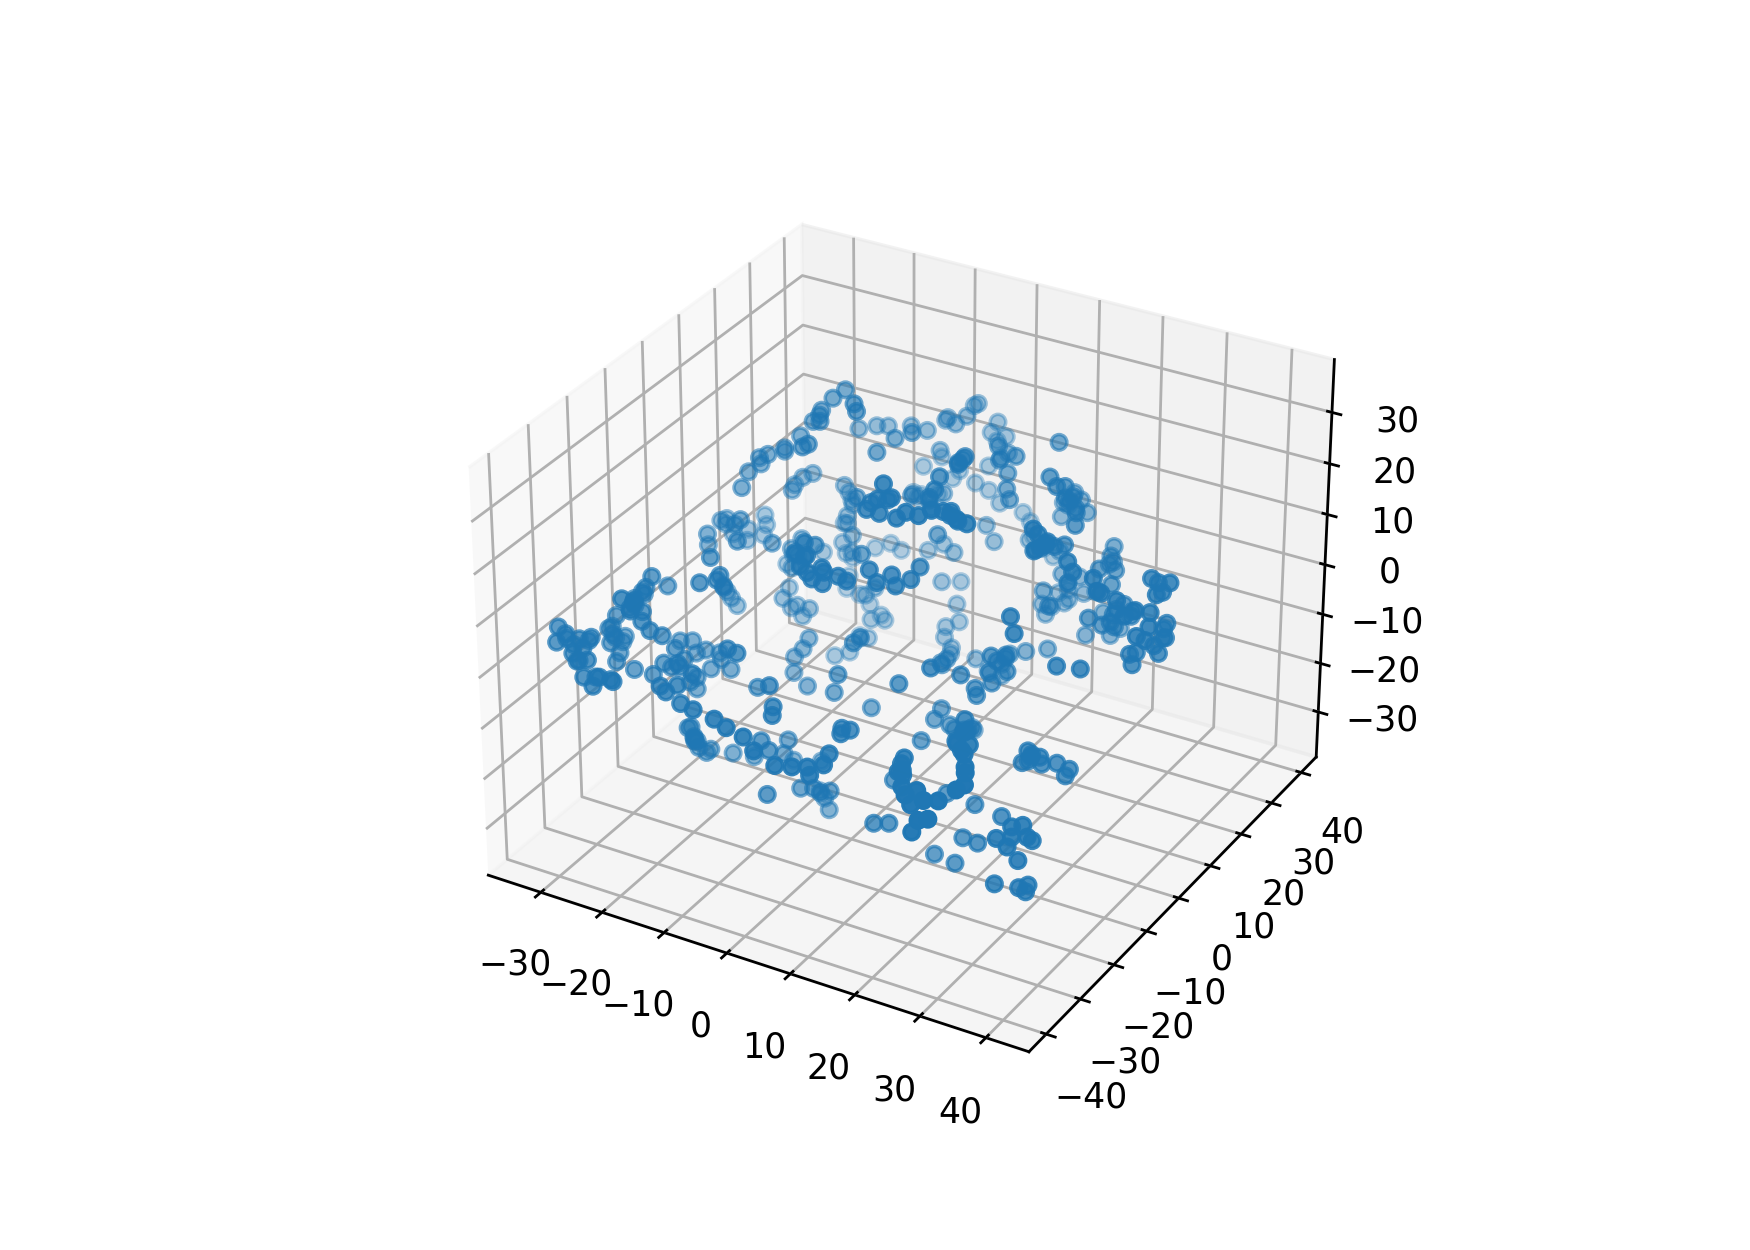

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d', adjustable='box')
ax.scatter(x, y, z,  marker='o')
plt.show()

The second argument of this function specifies the thresholding parameter. Setting a too low value for this parameter will add some outliers to the point cloud and setting it too high will result in ignoring some details of the map.

In [10]:
x, y, z = sample('Data/emd_1717.map', 72, 500, random_seed=1)
xl, yl, zl = sample('Data/emd_1717.map', 10, 500, random_seed=1)
xh, yh, zh = sample('Data/emd_1717.map', 100, 500, random_seed=1)

<IPython.core.display.Javascript object>


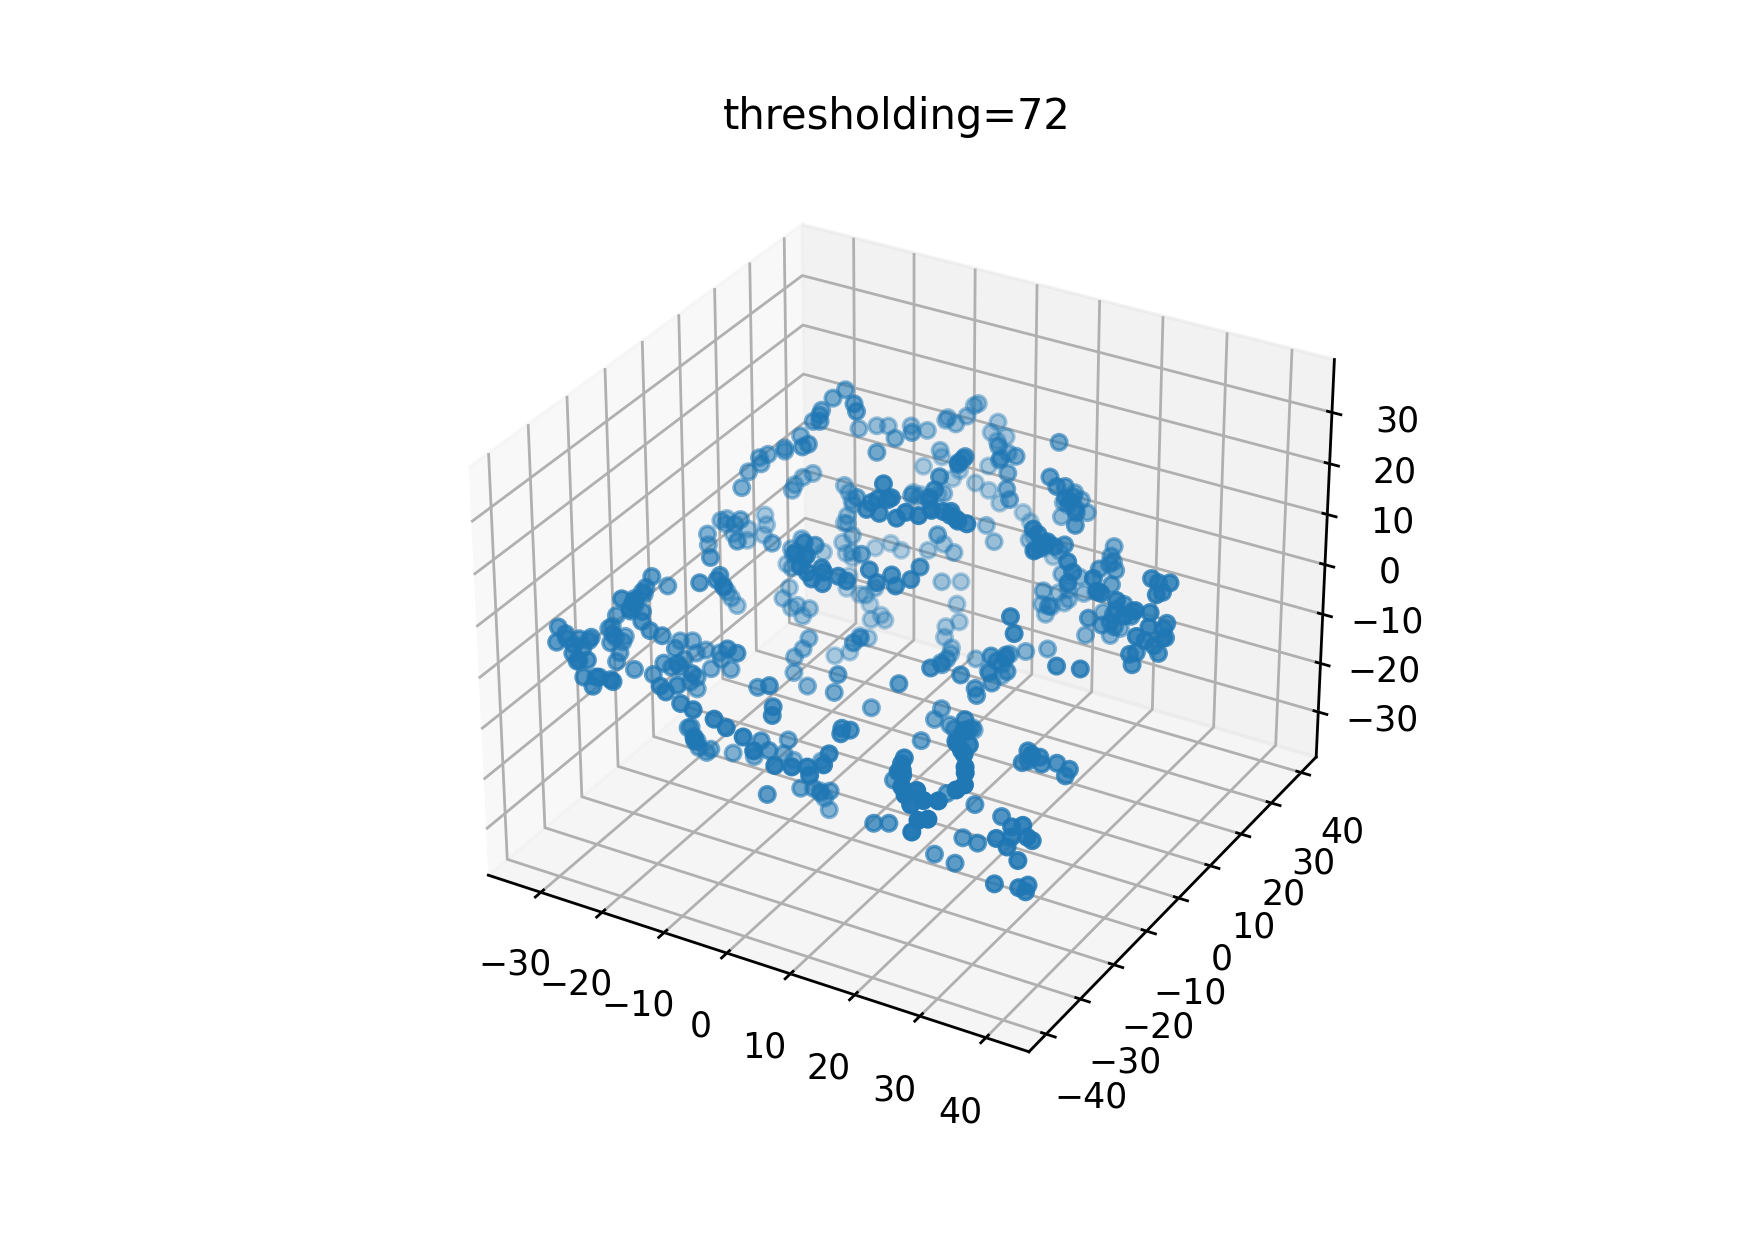

<IPython.core.display.Javascript object>


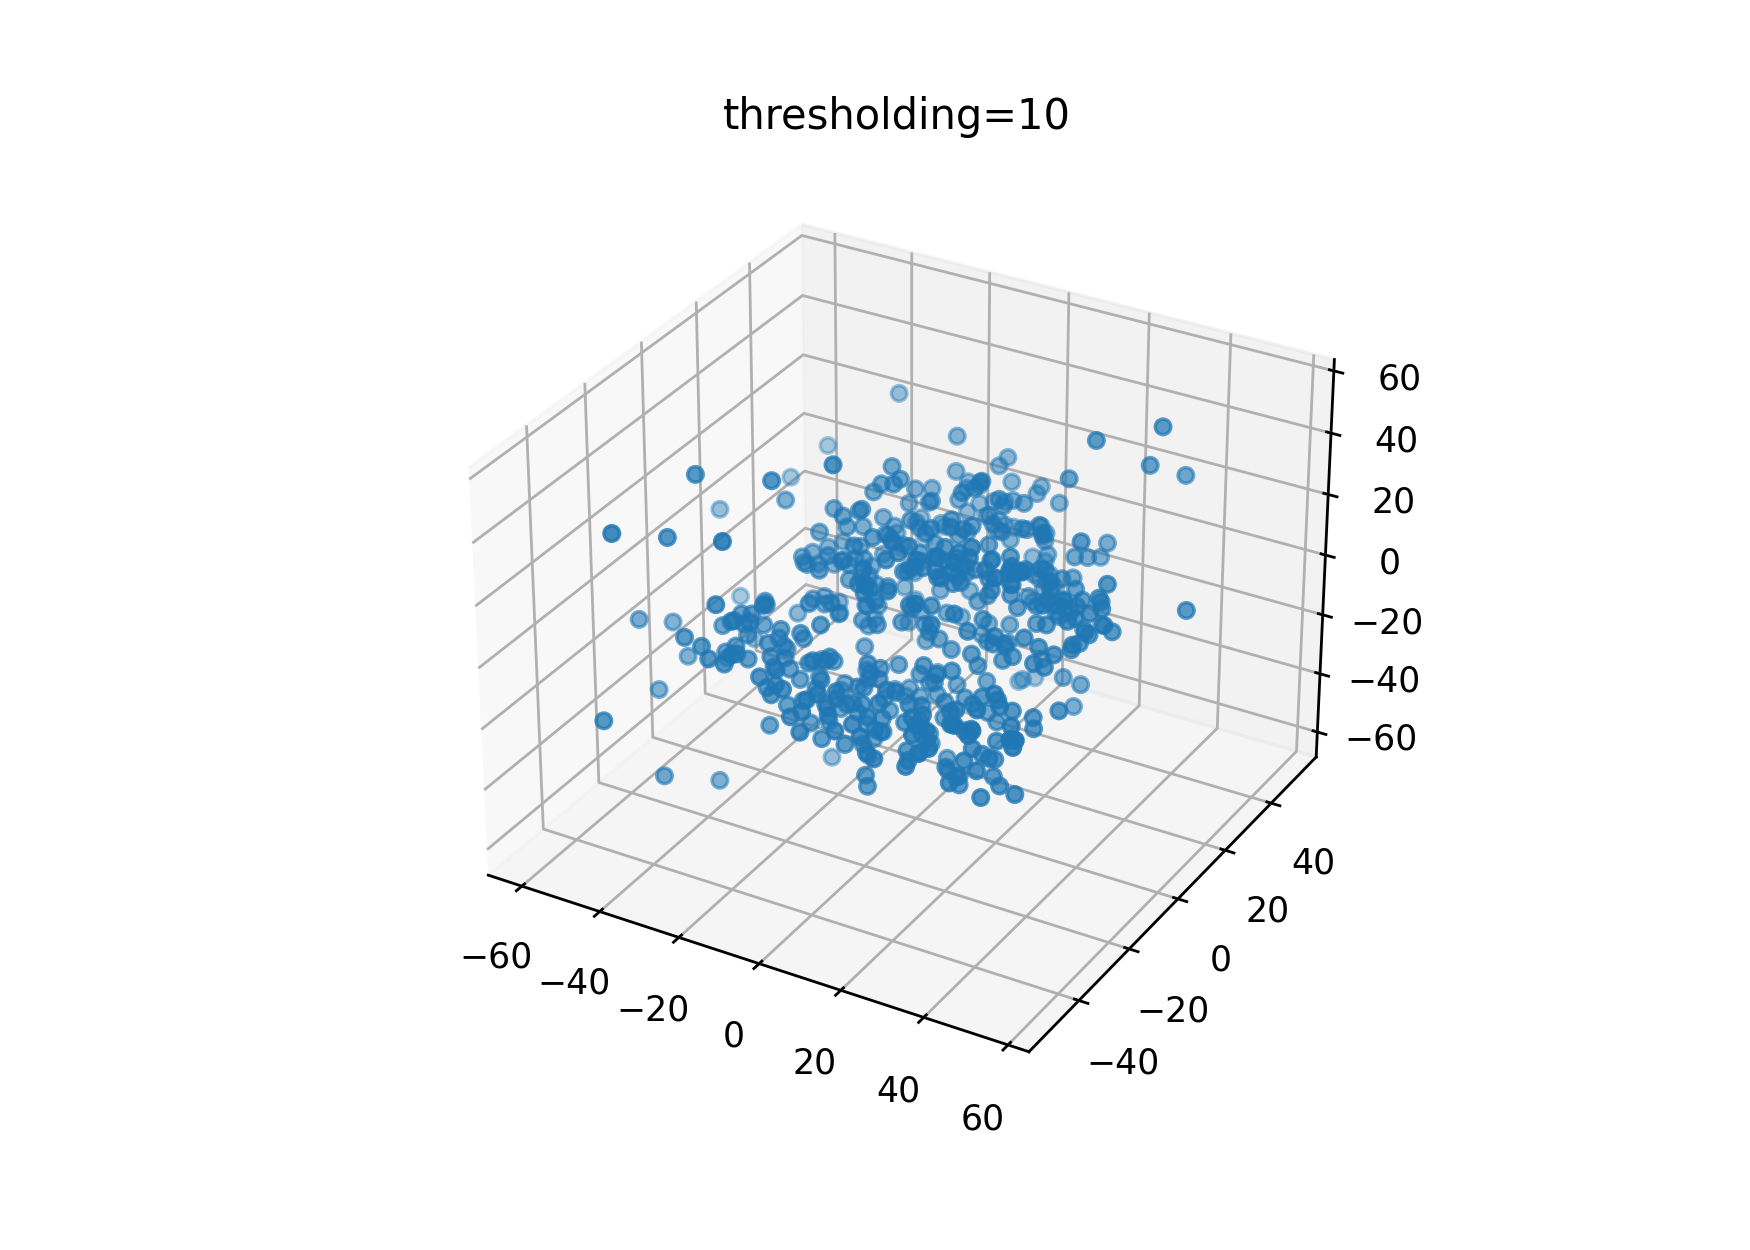

<IPython.core.display.Javascript object>


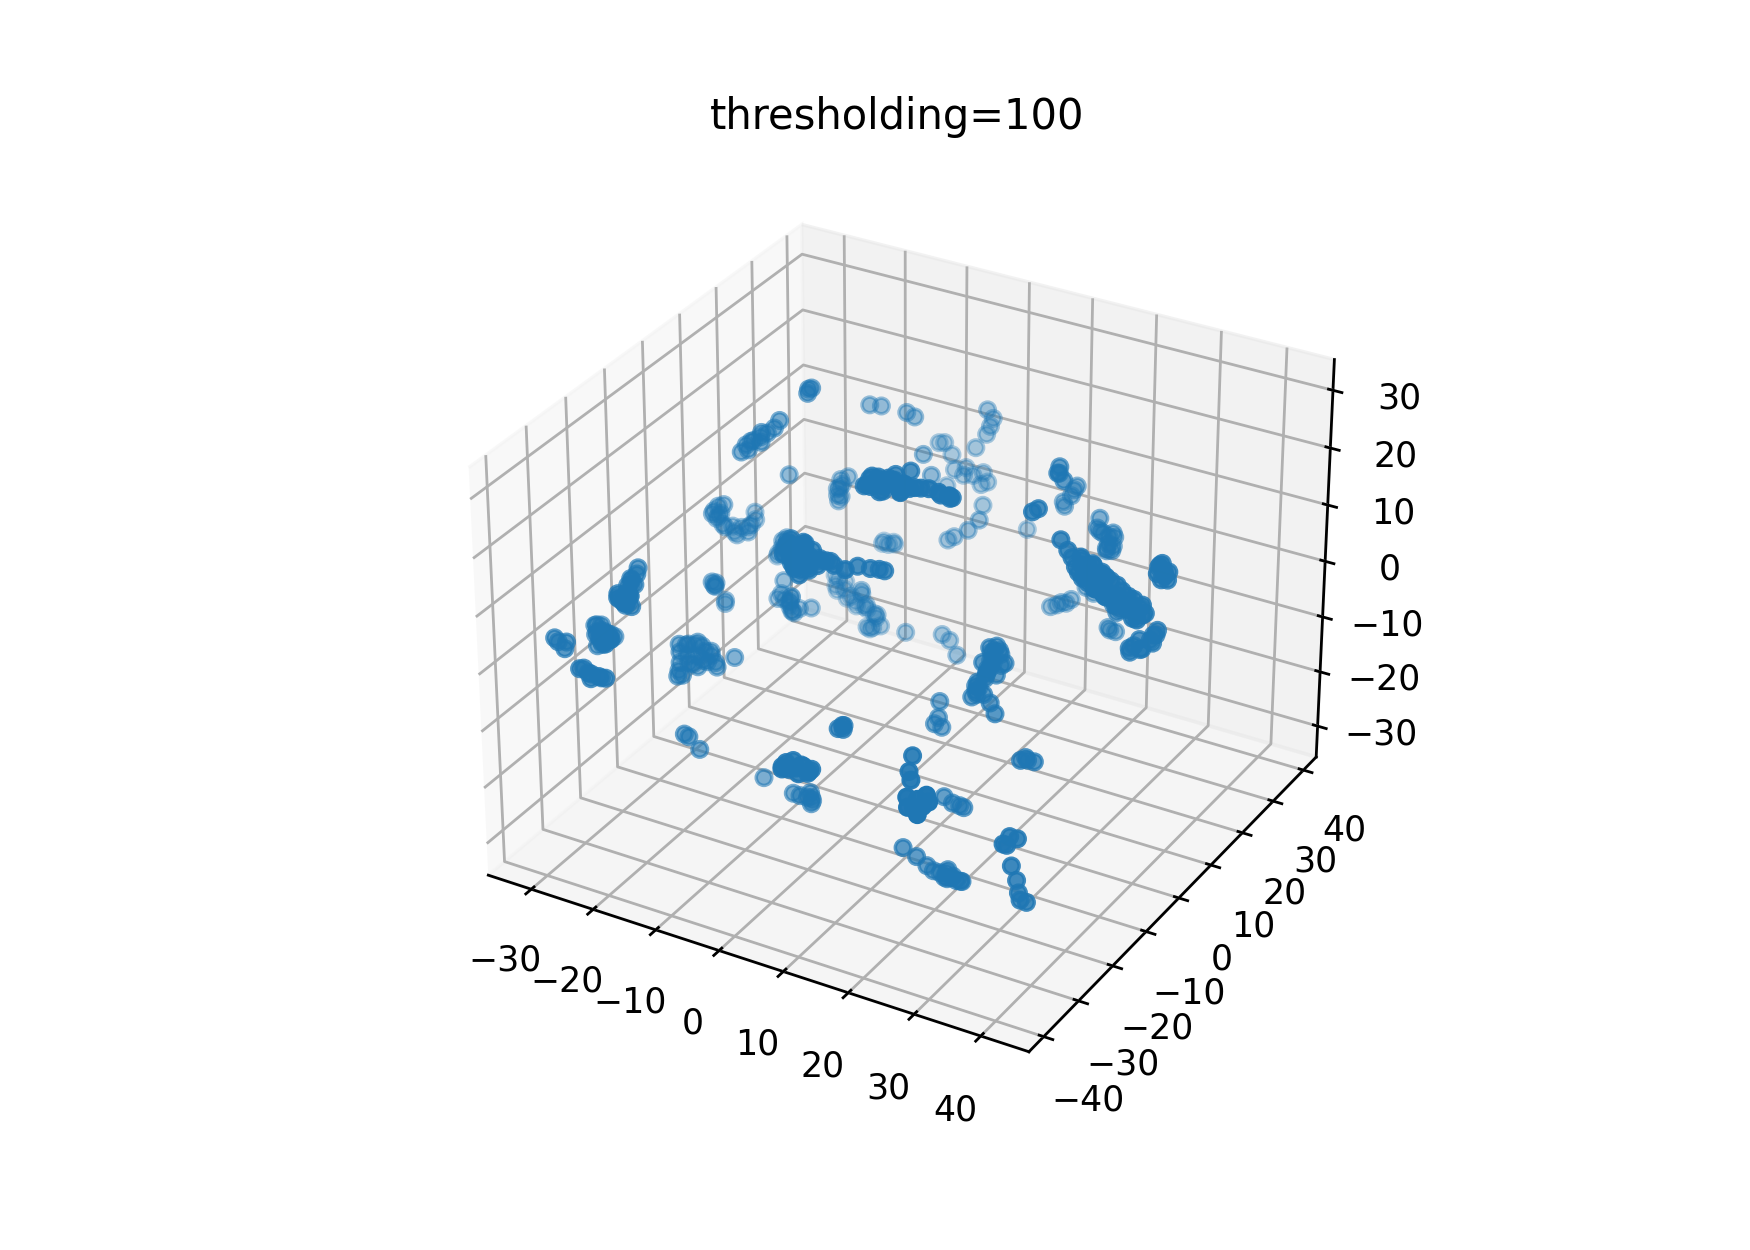

In [11]:
fig = plt.figure()
ax = fig.gca(projection='3d', adjustable='box')
ax.scatter(x, y, z,  marker='o')
plt.title('thresholding=72')
plt.show()
fig = plt.figure()
ax = fig.gca(projection='3d', adjustable='box')
ax.scatter(xl, yl, zl,  marker='o')
plt.title('thresholding=10')
plt.show()
fig = plt.figure()
ax = fig.gca(projection='3d', adjustable='box')
ax.scatter(xh, yh, zh,  marker='o')
plt.title('thresholding=100')
plt.show()

To save and load computed point clouds we define the following functions.

In [12]:
def save_points(fname, x, y, z):
    f = open(fname, 'w')
    f.write(json.dumps({'x':x, 'y':y, 'z':z}))
    f.close()

def load_points(fname):
    f = open(fname, 'r')
    j = json.loads(f.read())
    f.close()
    return j['x'], j['y'], j['z']

In [13]:
save_points('Data/sample_points=500_1.points', x, y, z)

In [14]:
x, y, z = load_points('Data/sample_points=500_1.points')

As one may prefer to illustrate point clouds in ChimeraX, we have written the following function to export a given point cloud as a ChimeraX command file containing information about the point cloud. You could open the generated file with ChimeraX to visualize the point cloud.

In [15]:
def export_to_chimera(x, y, z, fname_map, fname_out, color='#55aaff', size=5):
    map_mrc = mrcfile.open(fname_map)
    N_cube = max(map_mrc.header.tolist()[0],map_mrc.header.tolist()[1],map_mrc.header.tolist()[2])
    N_cube += N_cube%2
    f = open(fname_out, 'w')
    for i in range(len(x)):

        z_temp = map_mrc.header.tolist()[24][2] + map_mrc.header.tolist()[10][2] * ((x[i] + N_cube//2)) / map_mrc.header.tolist()[2]
        y_temp = map_mrc.header.tolist()[24][1] + map_mrc.header.tolist()[10][1] * ((y[i] + N_cube//2)) / map_mrc.header.tolist()[1]
        x_temp = map_mrc.header.tolist()[24][0] + map_mrc.header.tolist()[10][0] * ((z[i] + N_cube//2)) / map_mrc.header.tolist()[0]

        f.write('shape sphere center %f,%f,%f color %s radius %d\n'%(x_temp,y_temp,z_temp,color,size))
    f.close()

In [16]:
export_to_chimera(x, y, z, 'Data/emd_1717.map', 'Data/sample.cxc')

![](images/emd1717_full.png)

# 3. Search Method

## 3.1. Translation

As we said in the introduction section, our goal is to find a 3D rotation and a translation vector that align two given point clouds. For this, we find a 3D rotation and a translation vector that minimize the following cost function.

\begin{align}
\mathcal{L}(R, T) = \mathcal{W}_{2,\epsilon}^2(\text{move}_{R,T}(\mathbf{A}),\mathbf{B})^2. \label{eq:loss}\tag{1}
\end{align}

To minimize the loss function \eqref{eq:loss}, we first solve the problem of finding the optimal translation $T$.        
Assume $\mathbf{A}=\{a_1,a_2,\dots,a_n\},\mathbf{B}=\{b_1,b_2,\dots,b_n\}$. Upon introducing the centers of mass $\overline{a} = \frac{1}{n}\sum_{i=1}^n a_i$ and $\overline{b} = \frac{1}{n}\sum_{i=1}^n b_i$, and the centered coordinates $a_{c_i} = a_i - \overline{a}$ and $b_{c_i} = b_i - \overline{b}$, and using the definition  of Wasserstein distance, equation \eqref{eq:loss} yields

\begin{align}
\mathcal{L}(R, T) &= \mathcal{W}_{2,\epsilon}(\text{move}_{R,T}(\mathbf{A}),\mathbf{B})^2\\
&= \min_{P \in \mathbb{R}_+^{n \times n}} \sum_{i,j=1}^n ||Ra_i+T-b_j||_2^2P_{i, j} + \epsilon H(P) \quad(\textrm{s.t.} \quad  \forall 1 \le j \le n: \sum_{i=1}^n P_{i,j} = \sum_{i=1}^n P_{j,i} = \frac{1}{n})\\
&= \min_{P \in \mathbb{R}_+^{n \times n}} \sum_{i,j=1}^n ||Ra_{c_i} + R\overline{a} + T - b_{c_j} - \overline{b}||_2^2P_{i, j} + \epsilon H(P) \quad(\textrm{s.t.} \quad  \forall 1 \le j \le n: \sum_{i=1}^n P_{i,j} = \sum_{i=1}^n P_{j,i} = \frac{1}{n})\\
&= \min_{P \in \mathbb{R}_+^{n \times n}} \sum_{i,j=1}^n ||Ra_{c_i} - b_{c_j}||_2^2P_{i, j}  + \sum_{i,j=1}^n||R\overline{a} + T - \overline{b}||_2^2P_{i, j}  + \sum_{i,j=1}^n(Ra_{c_i} - b_{c_j}).(R\overline{a} + T - \overline{b})P_{i, j} + \epsilon H(P) \label{eq:loss2}\tag{2}\\
&= \min_{P \in \mathbb{R}_+^{n \times n}} \sum_{i,j=1}^n ||Ra_{c_i} - b_{c_j}||_2^2P_{i, j} + \sum_{i,j=1}^n||R\overline{a} + T - \overline{b}||_2^2P_{i, j} + \epsilon H(P)\label{eq:clear}\tag{3}\\
&= \min_{P \in \mathbb{R}_+^{n \times n}} \big(\sum_{i,j=1}^n ||Ra_{c_i} - b_{c_j}||_2^2P_{i, j} + \epsilon H(P)\big) + ||R\overline{a} + T - \overline{b}||_2^2\label{eq:loss3}\tag{4}
\end{align}

where we used in \eqref{eq:loss2} that $\sum_{i,j=1}^n P_{i,j}a_{c_i} = \frac{1}{n}\sum_{i=1}^n a_{c_i} =0$ and $\sum_{i,j=1}^n P_{i,j}b_{c_j} = \frac{1}{n}\sum_{j=1}^n b_{c_j} = 0$. 
Also, we used the fact that $\sum_{i,j=1}^n P_{i,j} = 1$ in \eqref{eq:clear}.
The second term in eq. \eqref{eq:loss3} is minimized for $T = \overline{b} - R \overline{a}$, i.e. the translation that aligns the two centers of mass. Therefore, to solve the rigid body alignment problem, we can now assume for the rest of this section that the distributions of points $\mathbf{A}$ and $\mathbf{B}$ are both centered at the origin, and that we only need to solve the optimization problem over the rotations in $SO(3)$. So, for the rest we only need to find an appropriate rotation.

    
    

In terms of code we write the following function to translate a given point cloud towards origin and inverse.

In [17]:
def translate(x_i, y_i, z_i, x_t=None, y_t=None, z_t=None):
    if x_t is None:
        x_t = -sum(x_i)/len(x_i)
        y_t = -sum(y_i)/len(y_i)
        z_t = -sum(z_i)/len(z_i)
      
    x_new = []
    y_new = []
    z_new = []
    for i in range(len(x_i)):
        x_new.append(x_i[i] + x_t)
        y_new.append(y_i[i] + y_t)
        z_new.append(z_i[i] + z_t)
    
    return x_new, y_new, z_new

In [18]:
x, y, z = translate(x, y, z)
print(np.mean(x))
print(np.mean(y))
print(np.mean(z))

3.410605131648481e-16
1.0231815394945442e-15
9.663381206337363e-16


## 3.2. Rotation

As a result of the previous section, the main part of the project is to find the optimal rotation. For this, we apply stochastic gradient descent to the Wasserstein distance between two distribution of points. In other words, in each iteration, we randomly select a point and then update parameters with the gradient of the loss function.

In [19]:
def dot(a, b):
    s = 0
    for i in range(4):
        s += a[i] * b[i]
    return s

def SGD(x, y, z, xr, yr, zr, lr=0.005, max_iter=100, reg=0.1, num_samples=1, verbose=False, random_seed=None):
    
    q = Quaternion(Polynomial([Term(coef=1, exps=[1,0,0,0])]), Polynomial([Term(coef=1, exps=[0,1,0,0])]), 
                   Polynomial([Term(coef=1, exps=[0,0,1,0])]), Polynomial([Term(coef=1, exps=[0,0,0,1])]))
    qs = q.conjugate()
    
    p = Quaternion(Polynomial([Term(coef=0, exps=[0,0,0,0])]), Polynomial([Term(coef=1, exps=[0,0,0,0])]), 
                   Polynomial([Term(coef=1, exps=[0,0,0,0])]), Polynomial([Term(coef=1, exps=[0,0,0,0])]))

    b = q*p*qs
    
    px = Quaternion(Polynomial([Term(coef=0, exps=[0,0,0,0,1,0,0,0])]), Polynomial([Term(coef=1, exps=[0,0,0,0,0,1,0,0])]), 
                Polynomial([Term(coef=1, exps=[0,0,0,0,0,0,1,0])]), Polynomial([Term(coef=1, exps=[0,0,0,0,0,0,0,1])]))

    bx = q*px*qs
    i_der = []
    j_der = []
    k_der = []
    for i in range(4):
        i_der.append(bx.i_pol.derivative(i))
        j_der.append(bx.j_pol.derivative(i))
        k_der.append(bx.k_pol.derivative(i))

    if random_seed is not None:
        random.seed(random_seed)
    
    vals = get_quaternion_vals(0, 0, 0, 1)
    quaternions = []
    costs = []
    OT_time = 0
    grad_time = 0
    sample_time = 0
    rotate_time = 0
    prev = None
    u = None
    v = None
    for i in range(max_iter):
        t = time.time()
        if verbose:
            if i % 10 == 9:
                print('Iteration number %d, the wasserstein deistance is %.2f'%(i, costs[-1]))
        quaternions.append([])
        for j in range(4):
            quaternions[-1].append(vals[j])
        
        xx,yy,zz = perform(x, y, z, vals)
        rotate_time += time.time() - t
        
        t = time.time()
        if u is not None:
            prev = (u,v)
        T,cost,u,v = OT(xr,yr,zr,xx,yy,zz,reg=reg,prev=prev)
        costs.append(cost)
        OT_time += time.time() -t
        t = time.time()
        
        for s in range(num_samples):
            sample_point = int(random.random()* len(x))
            
            

            x1 = x[sample_point]
            y1 = y[sample_point]
            z1 = z[sample_point]
            dest = None
            maxx = 0
            for j in range(len(x)):
                if T[sample_point][j] * len(x) > maxx:
                    maxx = T[sample_point][j] * len(x)
                    dest = j
            x2 = xr[dest]
            y2 = yr[dest]
            z2 = zr[dest]
            
            
            norm_grad = 0
            sample_time += time.time() - t
            t = time.time()

            grad = [0, 0, 0, 0]

            new_vals = []
            for k in range(4):
                new_vals.append(vals[k])
            new_vals.append(0)
            new_vals.append(x1)
            new_vals.append(y1)
            new_vals.append(z1)

            i_vals = bx.i_pol.evaluate(new_vals)
            i_der_vals = []
            j_vals = bx.j_pol.evaluate(new_vals)
            j_der_vals = []
            k_vals = bx.k_pol.evaluate(new_vals)
            k_der_vals = []
            for k in range(4):
                i_der_vals.append(i_der[k].evaluate(new_vals))
                j_der_vals.append(j_der[k].evaluate(new_vals))
                k_der_vals.append(k_der[k].evaluate(new_vals))
            

            for j in range(len(x)):
                if j != dest:
                    continue
                x2 = xr[j]
                y2 = yr[j]
                z2 = zr[j]

                temp = [0, 0, 0, 0]
                for k in range(4):

                    temp[k] += 2 * i_der_vals[k] * (i_vals - x2)
                    temp[k] += 2 * j_der_vals[k] * (j_vals - y2)
                    temp[k] += 2 * k_der_vals[k] * (k_vals - z2)

                    grad[k] += temp[k] * T[sample_point][j] * len(x) /num_samples
                    
        d_prod = dot(grad, vals)
        for j in range(4):
            grad[j] -= d_prod * vals[j]
        
        for j in range(4):
            vals[j] -= lr * grad[j]
        
        norm = math.sqrt(vals[0]**2 + vals[1]**2 + vals[2]**2 + vals[3]**2)
        for j in range(4):
            vals[j] /= norm
        
        norm_grad = math.sqrt(grad[0]**2 + grad[1]**2 + grad[2]**2 + grad[3]**2)
        grad_time += time.time() -t

    if verbose:
        print('Final cost: ' + str(costs[-1]))
        print('Time spent for optimal transport is ' + str(OT_time) + ' second(s).')
        print('Time spent for computing gradient is ' + str(grad_time) + ' second(s).')
        print('Time spent for rotating is ' + str(rotate_time) + ' second(s).')
        print('Time spent for sampling is ' + str(sample_time) + ' second(s).')
        print('Total time spent is ' + str(sample_time + rotate_time + grad_time + OT_time) + ' second(s).')
    return quaternions, costs

Here is an example of our code.

In [20]:
x, y, z = sample('Data/emd_1717.map', 72, 500, random_seed=1)
xr, yr, zr = sample('Data/emd_1717.map', 72, 500, random_seed=2)
x, y, z = translate(x, y, z)
xr, yr, zr = translate(xr, yr, zr)
xr, yr, zr = perform(xr, yr, zr, get_quaternion_vals(30 * math.pi /180, 0, 1, 0))
quartenions, costs = SGD(x, y, z, xr, yr, zr, lr=0.00002, max_iter=500, reg=30, num_samples=1, verbose=True, random_seed=1)

Iteration number 9, the wasserstein deistance is 117.19
Iteration number 19, the wasserstein deistance is 116.20
Iteration number 29, the wasserstein deistance is 115.19
Iteration number 39, the wasserstein deistance is 115.69
Iteration number 49, the wasserstein deistance is 114.99
Iteration number 59, the wasserstein deistance is 112.87
Iteration number 69, the wasserstein deistance is 110.42
Iteration number 79, the wasserstein deistance is 107.99
Iteration number 89, the wasserstein deistance is 107.47
Iteration number 99, the wasserstein deistance is 105.16
Iteration number 109, the wasserstein deistance is 104.75
Iteration number 119, the wasserstein deistance is 102.54
Iteration number 129, the wasserstein deistance is 98.84
Iteration number 139, the wasserstein deistance is 97.58
Iteration number 149, the wasserstein deistance is 96.16
Iteration number 159, the wasserstein deistance is 93.65
Iteration number 169, the wasserstein deistance is 94.00
Iteration number 179, the wass

To evaluate the output and compare it with ground truth rotation we need to have a metric function that shows how close two rotations are. For this, the following function computes the angle of a rotation that converts these two rotations to each other.

In [21]:
def diff_quaternions(q1, q2):
    diff = (convert_to_poly(q1) * convert_to_poly(q2).conjugate()).real_pol.evaluate((0,0,0,0))
    if diff > 1:
        diff = 1
    elif diff < -1:
        diff = -1
    deg = math.acos(diff) * 2 * 180 / math.pi
    if deg > 180:
        return 360 - deg
    else:
        return deg

And here is an analysis of the output.

The final found quaternion is:
[0.9713459675703706, -0.0002384498658712079, 0.23734041403000783, -0.01250928832933273]
The ideal quaternion is:
[0.9659258262890683, 0.0, 0.25881904510252074, 0.0]
The angle difference is 2.92 degree(s).


<IPython.core.display.Javascript object>


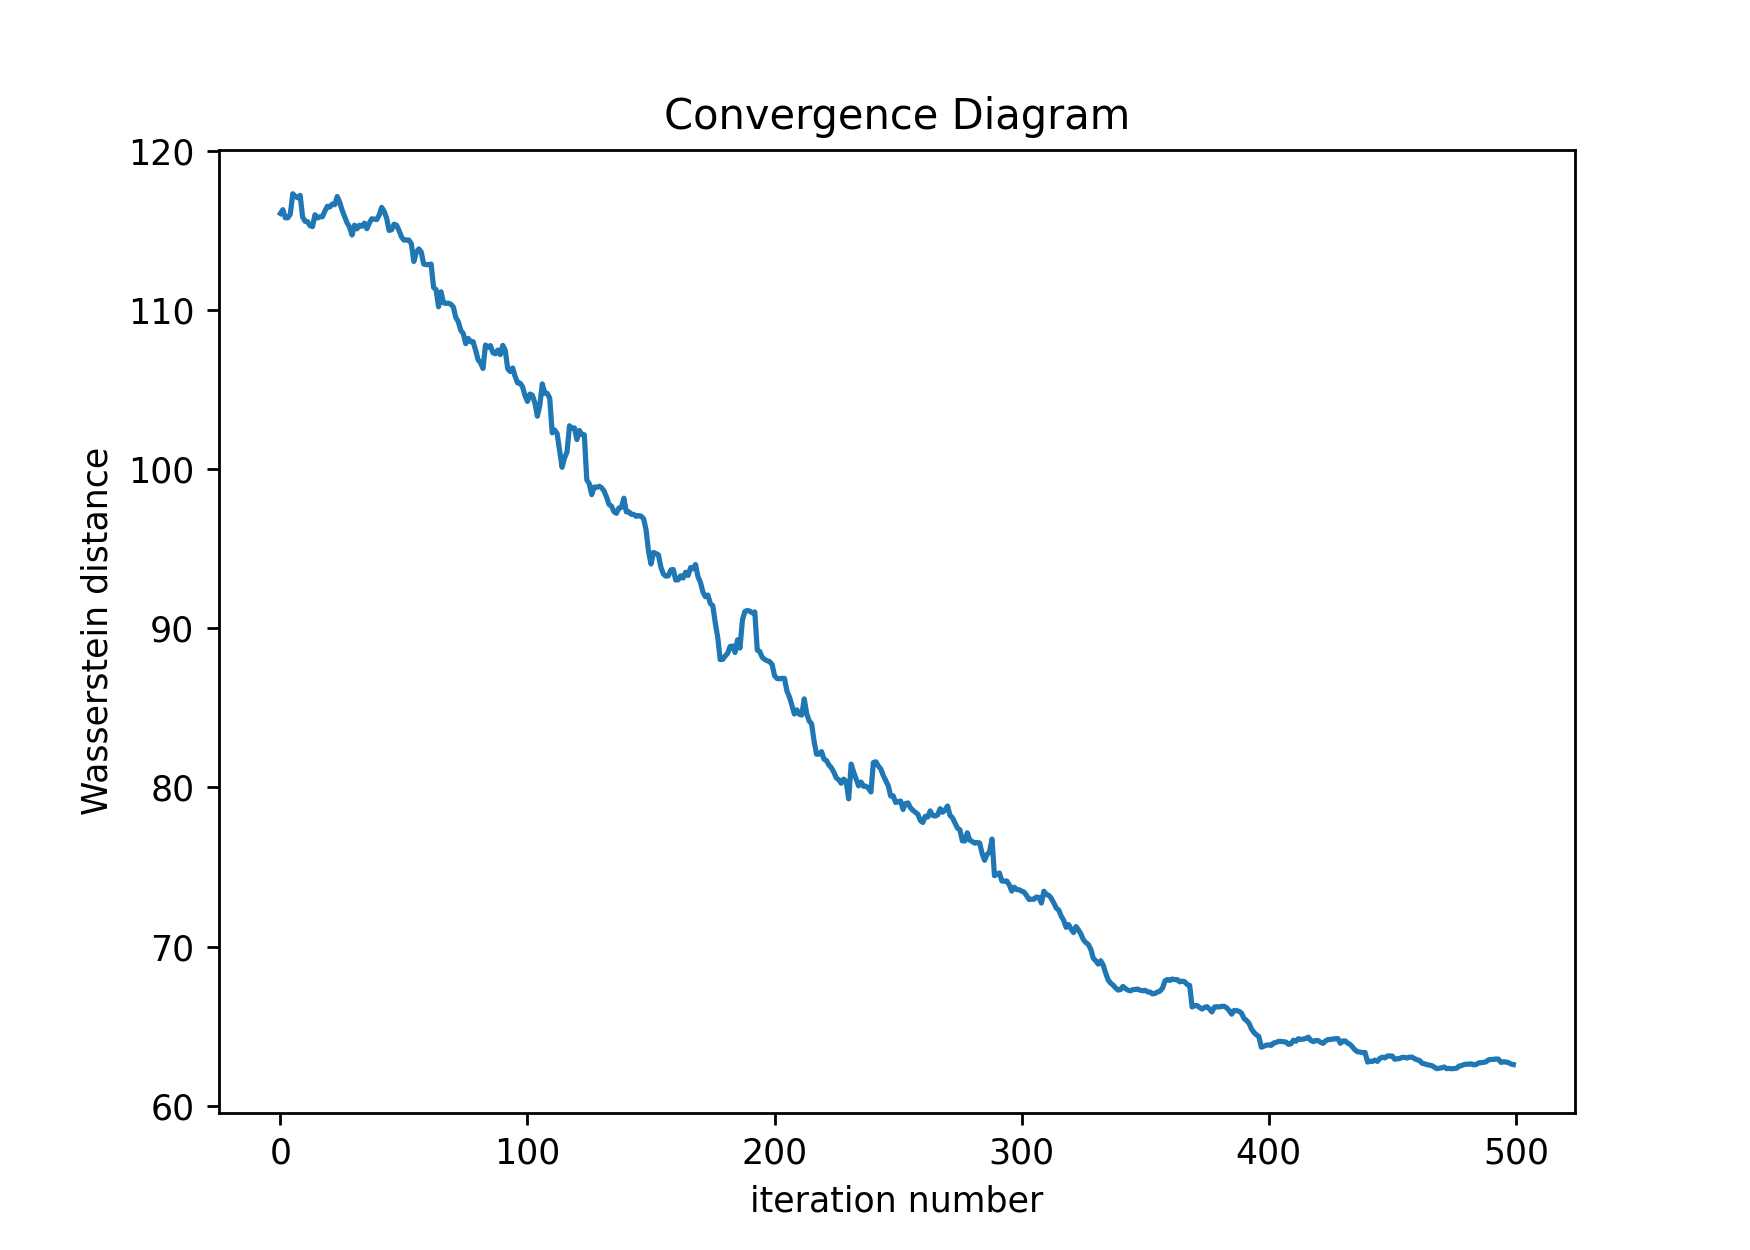

<IPython.core.display.Javascript object>


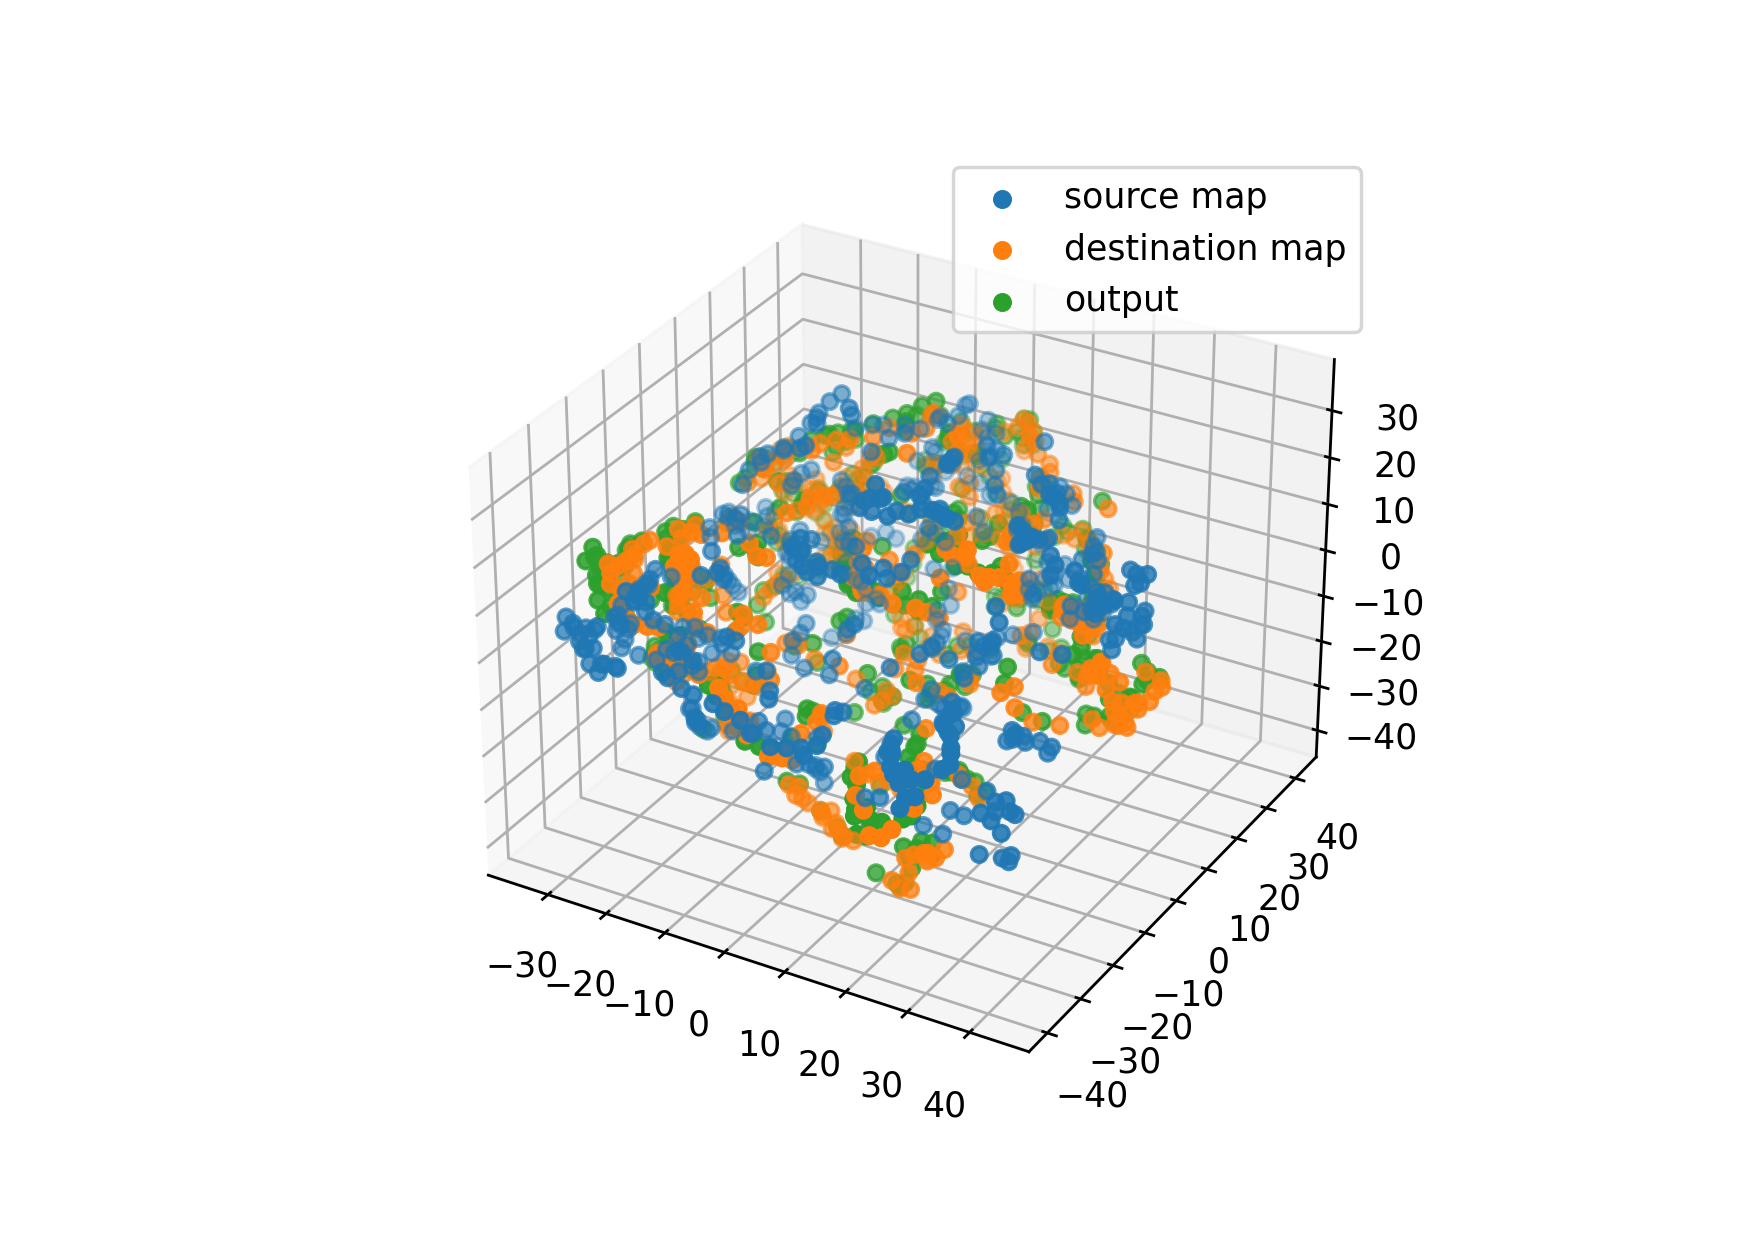

In [22]:
print("The final found quaternion is:")
print(quartenions[-1])
print("The ideal quaternion is:")
print(get_quaternion_vals(math.pi/6, 0, 1, 0))
print("The angle difference is %0.2f degree(s)."%(diff_quaternions(quartenions[-1], get_quaternion_vals(math.pi/6, 0, 1, 0)),))


fig, ax = plt.subplots()
plt.title('Convergence Diagram')
plt.xlabel('iteration number')
plt.ylabel('Wasserstein distance')
plt.plot(costs)
plt.show()

x_fin, y_fin, z_fin = perform(x, y, z, quartenions[-1])

fig = plt.figure()
ax = fig.gca(projection='3d', adjustable='box')
ax.scatter(x, y, z, c='C0',  marker='o', label='source map')
ax.scatter(xr, yr, zr, c='C1', marker='o', label='destination map')
ax.scatter(x_fin, y_fin, z_fin, c='C2',  marker='o', label='output')
plt.legend()
plt.show()

The following GIF shows the procedure of aligning two copies of EMDB:1717 where $t$ represents the iteration number.
![](images/emd1717_gif.gif)

# 4. Evaluations
We test our method on two datasets of cryo-EM maps. The first dataset (Dataset1) consists of a single map of the ribosome (EMDB 1717). The map (that has a resolution of 20 Angstroms) is encoded as a $128^3$ voxel grid, with a voxel length of 2.8 Angstroms. The second dataset consists of 6 pairs of protein structures with conformational variations. We align these structures with the MMAlign method. After that, we use the `molmap` function in ChimeraX to convert protein structures to density maps. Then we run AlignOT and Chimera's `fitmap` function under various initial impositions (with different axes and angles of 45,60,90 degrees and axes sampled from a hemisphere) and with different hyperparameters (e.g. number of sampled points). All these maps can be found in `Data/` folder.

The details of these maps are provided in the following image.


![](images/maps5.svg)

These maps are chosen based on the experiments of the VESPER paper (presented in the class).

**References**

Han, Xusi, et al. "VESPER: global and local cryo-EM map alignment using local density vectors." Nature communications 12.1 (2021): 1-12.

The results of the benchmarking experiment are evaluated in the following table with two possible measurements. For each alignment, we calculate the angle difference between the final output and the ground truth (computed with MMAlign) as well as the regularized Wasserstein distance. For each of these measurements, we report the mean and the variance of multiple alignments. The regularization parameter used in the computation of the regularized Wasserstein distance is the same among all experiments. Also, for computing this metric we should sample our maps. The number of points used in sampling the results of AlignOT is the same as the number of points used in hyperparameters, however, this factor for Chimera's results and MMAlign is $500$.
![](images/results.png)

# 5. Conclusion
The results of our benchmarking experiment are quite promising. In the pairs ID=1,6, we see a strange phenomenon, where the performance of our algorithm is decreasing as the number of points has increased. This is exactly the opposite of what we expected (and we see in other pairs). The reason behind this happening is that increasing the number of points slows down the convergence of the algorithm. So in these two pairs, our algorithm didn't have enough time to converge. However, ever in these two pairs, we see good results for 250 sampled points so we conclude that the method could get even better results if we'd given it more time. Except for these two pairs almost everywhere else our method with 1000 points is almost always getting the best results.

The main limitation of this method is in aligning pairs that have partiality i.e. one part of one of the maps is not modeled in the other one. Our idea is to fix this issue using partial OT instead of regular OT, however, we need more work to do for translation part.

# Reviews
**Q:** We detected multiple typos across the notebook: ex. Introduction: Solvong the 3D structures of biomolecules -> Solving. Conclusion: ever in these two pairs -> even for these two pairs. Please carefully check the notebook to clean your notebook.  
**A:** Fixed.

**Q:** Introduction: There are typos. The motivation is not clear. Maybe keep the last sentence only and say that it's hard to see differences before maps are properly aligned  
**A:** Added some other applications with reference + some more descriptions of the project and our motivation.

**Q:** "Our goal is to find a 3D rotation and a translation vector that align two given point clouds." It is not clear why we're considering point clouds now and not voxel maps anymore? Why? This part also needs motivation for the choice of W2 for the distance.  
**A:** Added some explanations in the Introduction section regarding this issue.

**Q:** Quaternions: Please discuss why this way of representing SO(3) was chosen. Instead of implementing these classes, is it possible to use python libraries, such as scipy or geomstats? (In future, it'd be useful to provide unit tests with the functions written from scratch)  
**A:** To recall a summary of our method: AlignOT in each iteration, given quaternion $q$, (1) rotate the first input point cloud ($A$) with respect to $q$, (2) compute OT plan matrix between this new computed point cloud and the second input point cloud ($B$), (3) sample a point from $A$ and find its correspondence in $B$ ($a,b$), (4) compute the distance between $a$ and $b$ as a function of $q$ ($f(q)$), and (5) update $q$ with respect to the gradient of $f$. As a result, we need an implementation of quaternions that not only provides us the multiplication computation for rotating the point clouds but also gives us the possibility to compute the derivatives. So our model should see quaternions as $Q_1+ Q_2i + Q_3j + Q_4k$ where $Q_1,Q_2,Q_3,Q_4$ are **polynomials not real values**. The python libraries that I previously worked with (that includes ```scipy``` and ```pyquaternion```) consider quaternions as a combination of real values. Also, as our time reports in Section 3.2. suggests these computations take approximately about 6% of total time, in other words, our implementation is optimized enough, and using other highly optimized implementations won't provide us a significant speedup.

**Q:** Optimal transport: the motivation for writing new code is more clear, but you should back up claims like "simpler" with more arguments. (Also, unit tests would be useful for this too.)  
**A:** Unit tests are added. These unit tests generate random point clouds and compare the result of our OT component with the ```POT``` package. Also, minor arguments and a new reference are added.

**Q:** Topology Representing Network: Please clarify how the link with the reference cited is relevant here  
**A:** This paper analyzes the eukaryotic chaperonin TRiC/CCT. For this, it applies Topology Representing Networks (TRNs) to convert the cryo-EM density map to a network model. The provided mathematical description in Section 2.1. (page 3) exactly matches our implementation. I've also added a new reference for this part which is the first paper that introduced TRNs.

**Q:** 3.1 section: some equation doesn't get displayed and the labeling is not working  
**A:** I think I have a issue here with saving Jupyter notebook containing math quations. Please recompile that cell (Section 3.1.) after opening the notebook.

**Q:** \[l. 19\]: the times to not add up. Is there an issue here?  
**A:** No, it does add up. I think there is a misunderstanding with the logs. The term "Final cost" points out the Wasserstein distance of two point clouds after the last step, so it has nothing to do with the time. Total time was not displayed in the previous version as it was just a sum of other reported times. The logging system is changed a little bit so it looks more clear.

**Q:** The text in the Evaluations section needs to be reworked.  
**A:** Fixed!

**Q:** " however, we need more work to do for translation." -> we need to do more work. Clarify?  
**A:** The proof provided in Section 3.1. (for finding the translation vector) highly relies on the assumption that given two point clouds ($A, B$) for each point in $A$ there is one and exactly one corresponding point in $B$. This assumption is completely false if we substitute regular OT with partial OT in the definition of $\mathcal{L}(R, T)$ in Section 3.1. Consequently, we can immediately infer the best translation vector for alignment of $A, B$ which means we should do more work on this part.
